# Lineal Regression a+b(x)
# Numpy and Pandas 

In [133]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
dat = yf.Ticker("NVDA")
df = yf.download(["NVDA"], period='6mo')
df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
df.dropna(inplace=True)  # Remove rows with NaN values
df.tail()
df['Prev Close']

# df['Prev Close']

# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls




[*********************100%***********************]  1 of 1 completed


Ticker,NVDA
Date,
2024-09-13,119.131790
2024-09-16,119.091789
2024-09-17,116.771950
2024-09-18,115.582031
2024-09-19,113.362190
...,...
2025-03-06,117.300003
2025-03-07,110.570000
2025-03-10,112.690002


In [134]:
x = df["Prev Close"]
y = df["Close"]
# x = pd.DataFrame({'Date'})
x

Ticker,NVDA
Date,
2024-09-13,119.131790
2024-09-16,119.091789
2024-09-17,116.771950
2024-09-18,115.582031
2024-09-19,113.362190
...,...
2025-03-06,117.300003
2025-03-07,110.570000
2025-03-10,112.690002


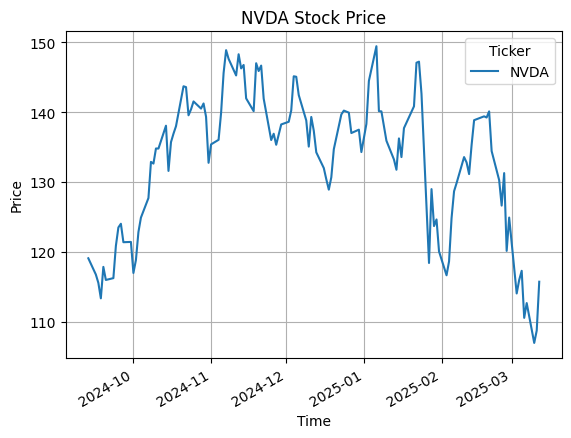

In [135]:
df["Close"].plot()
plt.title("NVDA Stock Price")
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(which="major")

In [136]:
def CreateTrainTestSet(x, y):
    features = x
    target = y

    data_len = x.shape[0]

    print("Historical data length: ", data_len)

    train_split = int(data_len * 0.88) # 88% training data
    print("Training data len: ", train_split)
    val_split = train_split + int(data_len * 0.1) # 10%
    print("Validation Set Len", val_split)
    X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
    Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


X_train, X_val, X_test, Y_train, Y_val, Y_test = CreateTrainTestSet(x, y)
x
# X_train, X_test, y_train, y_test = CreateTrainTestSet(x, y, test_size=0.2, random_state=42)

Historical data length:  123
Training data len:  108
Validation Set Len 120


Ticker,NVDA
Date,
2024-09-13,119.131790
2024-09-16,119.091789
2024-09-17,116.771950
2024-09-18,115.582031
2024-09-19,113.362190
...,...
2025-03-06,117.300003
2025-03-07,110.570000
2025-03-10,112.690002


In [137]:
from sklearn.linear_model import LinearRegression

print(X_train.head())
print(Y_train.head())
model = LinearRegression() 
model.fit(X_train, Y_train)

Ticker            NVDA
Date                  
2024-09-13  119.131790
2024-09-16  119.091789
2024-09-17  116.771950
2024-09-18  115.582031
2024-09-19  113.362190
Ticker            NVDA
Date                  
2024-09-13  119.091789
2024-09-16  116.771950
2024-09-17  115.582031
2024-09-18  113.362190
2024-09-19  117.861877


LinearRegression()